<a href="https://colab.research.google.com/github/dairxp/Py-Colab-ALD/blob/main/Inversioens_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELDA 1: Instalación de paquetes
!pip install geopandas pysal esda splot libpysal mapclassify -q

print("✅ Paquetes instalados correctamente")

✅ Paquetes instalados correctamente


In [ ]:
# CELDA 2: Importar librerías
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import zipfile
import warnings
warnings.filterwarnings('ignore')

print("✅ Librerías cargadas")

✅ Librerías cargadas


In [ ]:
# CELDA 3: Subir archivo
from google.colab import files

print("👉 Selecciona tu archivo: inversiones_precision_alta_FINAL_csv.zip")
uploaded = files.upload()

# Obtener nombre del archivo
zip_filename = list(uploaded.keys())[0]
print(f"✅ Archivo subido: {zip_filename}")

👉 Selecciona tu archivo: inversiones_precision_alta_FINAL_csv.zip


Saving inversiones_precision_alta_FINAL_csv.zip to inversiones_precision_alta_FINAL_csv.zip
✅ Archivo subido: inversiones_precision_alta_FINAL_csv.zip


In [ ]:
# CELDA 4: Cargar datos desde ZIP
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    csv_filename = zip_ref.namelist()[0]
    with zip_ref.open(csv_filename) as f:
        df = pd.read_csv(f)

print("="*80)
print("📊 DATOS CARGADOS")
print("="*80)
print(f"Total de proyectos: {len(df):,}")
print(f"Total de columnas: {len(df.columns)}")
print(f"\nPrimeras 3 filas:")
print(df.head(3))

📊 DATOS CARGADOS
Total de proyectos: 205,701
Total de columnas: 65

Primeras 3 filas:
  NIVEL                SECTOR                          ENTIDAD  CODIGO_UNICO  \
0    GR  GOBIERNOS REGIONALES          GOBIERNO REGIONAL PIURA     2457924.0   
1    GL     GOBIERNOS LOCALES  MUNICIPALIDAD DISTRITAL DE ACAS     2573187.0   
2    GL     GOBIERNOS LOCALES  MUNICIPALIDAD DISTRITAL DE ACAS     2564749.0   

   CODIGO_SNIP                                   NOMBRE_INVERSION   ESTADO  \
0      2457924  CREACION DE LA CAPACIDAD OPERATIVA DE LOS SERV...  CERRADO   
1      2573187  ADQUISICION DE EQUIPAMIENTO DE AMBIENTES COMPL...  CERRADO   
2      2564749  CREACION DE LA TROCHA CARROZABLE DE LOS SECTOR...  CERRADO   

  SITUACION  MONTO_VIABLE  COSTO_ACTUALIZADO  ...  DEPARTAMENTO  PROVINCIA  \
0    VIABLE    7695126.31         7647891.31  ...         PIURA    AYABACA   
1  APROBADO      53152.64           53152.64  ...        ANCASH      OCROS   
2    VIABLE     496438.87          496438.87  

In [ ]:
# CELDA 5: Limpieza de datos
print("🧹 Iniciando limpieza...")

# Convertir fechas
df['FECHA_VIABILIDAD'] = pd.to_datetime(df['FECHA_VIABILIDAD'],
                                         format='%d/%m/%Y %H:%M',
                                         errors='coerce')
df['anio_viabilidad'] = df['FECHA_VIABILIDAD'].dt.year

# Filtrar proyectos con coordenadas válidas
df_clean = df.dropna(subset=['LATITUD', 'LONGITUD']).copy()

# Filtrar valores financieros válidos
df_clean = df_clean[(df_clean['MONTO_VIABLE'] > 0) &
                    (df_clean['DEVEN_ACUMULADO'] >= 0)]

# Calcular tasa de ejecución
df_clean['tasa_ejecucion'] = (df_clean['DEVEN_ACUMULADO'] /
                                df_clean['MONTO_VIABLE']) * 100
df_clean['tasa_ejecucion'] = df_clean['tasa_ejecucion'].clip(0, 100)

print(f"✅ Proyectos después de limpieza: {len(df_clean):,}")
print(f"✅ Período: {df_clean['anio_viabilidad'].min()} - {df_clean['anio_viabilidad'].max()}")
print(f"✅ Tasa ejecución promedio: {df_clean['tasa_ejecucion'].mean():.2f}%")

🧹 Iniciando limpieza...
✅ Proyectos después de limpieza: 205,701
✅ Período: 2002 - 2025
✅ Tasa ejecución promedio: 68.33%


In [ ]:
# CELDA 6: Convertir a GeoDataFrame
print("🗺️ Creando GeoDataFrame...")

# Crear geometría de puntos
geometry = [Point(xy) for xy in zip(df_clean['LONGITUD'], df_clean['LATITUD'])]
gdf = gpd.GeoDataFrame(df_clean, geometry=geometry, crs='EPSG:4326')

print(f"✅ GeoDataFrame creado con {len(gdf):,} proyectos georreferenciados")
print(f"✅ Sistema de coordenadas: {gdf.crs}")

🗺️ Creando GeoDataFrame...
✅ GeoDataFrame creado con 205,701 proyectos georreferenciados
✅ Sistema de coordenadas: EPSG:4326


In [ ]:
# CELDA 7: Agregación ponderada por distrito
print("📍 Agregando datos a nivel distrital...")

# Agrupar por distrito y calcular tasa de ejecución ponderada
distrito_agg = gdf.groupby('UBIGEO').apply(lambda x: pd.Series({
    'DEPARTAMENTO': x['DEPARTAMENTO'].iloc[0],
    'PROVINCIA': x['PROVINCIA'].iloc[0],
    'DISTRITO': x['DISTRITO'].iloc[0],
    'n_proyectos': len(x),
    'monto_viable_total': x['MONTO_VIABLE'].sum(),
    'devengado_total': x['DEVEN_ACUMULADO'].sum(),
    'tasa_ejecucion_ponderada': (x['DEVEN_ACUMULADO'].sum() / x['MONTO_VIABLE'].sum()) * 100,
    'latitud_centroid': x['LATITUD'].mean(),
    'longitud_centroid': x['LONGITUD'].mean()
})).reset_index()

print(f"✅ Agregación completada")
print(f"✅ Total de distritos con proyectos: {len(distrito_agg):,}")
print(f"\nEstadísticas de tasa de ejecución distrital:")
print(distrito_agg['tasa_ejecucion_ponderada'].describe())

📍 Agregando datos a nivel distrital...
✅ Agregación completada
✅ Total de distritos con proyectos: 1,819

Estadísticas de tasa de ejecución distrital:
count    1819.000000
mean       66.358578
std        28.537632
min         0.000000
25%        46.982652
50%        67.447133
75%        85.238580
max       242.095861
Name: tasa_ejecucion_ponderada, dtype: float64


In [ ]:
# CELDA 8: Agregación por distrito y nivel de gobierno
print("📊 Agregando por nivel de gobierno...")

# Crear agregación por distrito + nivel
distrito_nivel = gdf.groupby(['UBIGEO', 'NIVEL']).apply(lambda x: pd.Series({
    'DEPARTAMENTO': x['DEPARTAMENTO'].iloc[0],
    'PROVINCIA': x['PROVINCIA'].iloc[0],
    'DISTRITO': x['DISTRITO'].iloc[0],
    'n_proyectos': len(x),
    'monto_viable_total': x['MONTO_VIABLE'].sum(),
    'devengado_total': x['DEVEN_ACUMULADO'].sum(),
    'tasa_ejecucion': (x['DEVEN_ACUMULADO'].sum() / x['MONTO_VIABLE'].sum()) * 100,
    'latitud': x['LATITUD'].mean(),
    'longitud': x['LONGITUD'].mean()
})).reset_index()

print(f"✅ Datos agregados por nivel de gobierno")
print(f"\nProyectos por nivel:")
print(distrito_nivel.groupby('NIVEL')['n_proyectos'].sum())

📊 Agregando por nivel de gobierno...
✅ Datos agregados por nivel de gobierno

Proyectos por nivel:
NIVEL
GL    120496
GN     65752
GR     19453
Name: n_proyectos, dtype: int64


In [ ]:
# CELDA 9: GeoDataFrame a nivel distrital
print("🎯 Creando GeoDataFrame distrital...")

# Crear geometría para centroides distritales
geometry_dist = [Point(xy) for xy in zip(distrito_agg['longitud_centroid'],
                                          distrito_agg['latitud_centroid'])]
gdf_distritos = gpd.GeoDataFrame(distrito_agg, geometry=geometry_dist, crs='EPSG:4326')

print(f"✅ GeoDataFrame distrital creado: {len(gdf_distritos):,} distritos")
print(f"\nPrimeros 5 distritos:")
print(gdf_distritos[['DEPARTAMENTO', 'DISTRITO', 'n_proyectos',
                      'tasa_ejecucion_ponderada']].head())

🎯 Creando GeoDataFrame distrital...
✅ GeoDataFrame distrital creado: 1,819 distritos

Primeros 5 distritos:
  DEPARTAMENTO     DISTRITO  n_proyectos  tasa_ejecucion_ponderada
0     AMAZONAS  CHACHAPOYAS          278                 54.323810
1     AMAZONAS     ASUNCION           50                 92.753650
2     AMAZONAS       BALSAS           42                 53.480841
3     AMAZONAS        CHETO           76                 36.976051
4     AMAZONAS    CHILIQUIN           68                 45.404130


In [ ]:
# CELDA 10: Guardar datos limpios
print("💾 Guardando datos procesados...")

# Guardar CSV
distrito_agg.to_csv('datos_distritales_agregados.csv', index=False)
distrito_nivel.to_csv('datos_distrito_nivel.csv', index=False)

# Guardar GeoJSON para análisis espacial
gdf_distritos.to_file('distritos_geojson.geojson', driver='GeoJSON')

print("✅ Archivos guardados:")
print("   - datos_distritales_agregados.csv")
print("   - datos_distrito_nivel.csv")
print("   - distritos_geojson.geojson")

💾 Guardando datos procesados...
✅ Archivos guardados:
   - datos_distritales_agregados.csv
   - datos_distrito_nivel.csv
   - distritos_geojson.geojson


In [ ]:
# CELDA 11: Crear matriz de pesos espaciales
from libpysal.weights import DistanceBand
import libpysal as lp

print("📐 Construyendo matriz de pesos espaciales...")

# Extraer coordenadas de centroides
coords = list(zip(gdf_distritos['longitud_centroid'],
                  gdf_distritos['latitud_centroid']))

# Crear matriz de distancia inversa con umbral de 100 km
# NOTA: Coordenadas en grados, aproximadamente 1 grado = 111 km
# 100 km ≈ 0.9 grados
threshold = 0.9  # ~100 km en grados

w = DistanceBand(coords, threshold=threshold, binary=False, alpha=-1)

# Estandarizar por filas
w.transform = 'R'

print(f"✅ Matriz de pesos creada")
print(f"   - Distritos: {w.n}")
print(f"   - Promedio de vecinos: {w.mean_neighbors:.2f}")
print(f"   - Rango de vecinos: {w.min_neighbors} - {w.max_neighbors}")
print(f"   - Distritos sin vecinos (islas): {w.islands}")

📐 Construyendo matriz de pesos espaciales...
('WARNING: ', 1405, ' is an island (no neighbors)')
('WARNING: ', 1420, ' is an island (no neighbors)')
('WARNING: ', 1445, ' is an island (no neighbors)')
('WARNING: ', 1446, ' is an island (no neighbors)')
('WARNING: ', 1449, ' is an island (no neighbors)')
('WARNING: ', 1809, ' is an island (no neighbors)')
('WARNING: ', 1817, ' is an island (no neighbors)')
✅ Matriz de pesos creada
   - Distritos: 1819
   - Promedio de vecinos: 86.53
   - Rango de vecinos: 0 - 176
   - Distritos sin vecinos (islas): [1405, 1420, 1445, 1446, 1449, 1809, 1817]


In [ ]:
# CELDA 12: Moran Global
from esda.moran import Moran
import matplotlib.pyplot as plt

print("📊 Calculando Índice de Moran Global...")

# Preparar variable (tasa de ejecución)
y = gdf_distritos['tasa_ejecucion_ponderada'].values

# Calcular Moran's I
moran = Moran(y, w, permutations=9999)

print("="*80)
print("RESULTADOS: AUTOCORRELACIÓN ESPACIAL GLOBAL")
print("="*80)
print(f"Índice de Moran (I):        {moran.I:.4f}")
print(f"Valor esperado bajo H0:     {moran.EI:.4f}")
print(f"Varianza:                   {moran.VI_norm:.6f}")
print(f"Z-score:                    {moran.z_norm:.4f}")
print(f"P-value (permutaciones):    {moran.p_norm:.6f}")
print("="*80)

if moran.p_norm < 0.001:
    print("✅ RESULTADO: Autocorrelación espacial ALTAMENTE SIGNIFICATIVA (p<0.001)")
    if moran.I > 0:
        print("   → Patrón: CLUSTERING POSITIVO (valores similares están agrupados)")
    else:
        print("   → Patrón: DISPERSIÓN (valores disímiles están agrupados)")
elif moran.p_norm < 0.05:
    print("✅ RESULTADO: Autocorrelación espacial SIGNIFICATIVA (p<0.05)")
else:
    print("❌ RESULTADO: No hay evidencia de autocorrelación espacial")

📊 Calculando Índice de Moran Global...
RESULTADOS: AUTOCORRELACIÓN ESPACIAL GLOBAL
Índice de Moran (I):        0.0685
Valor esperado bajo H0:     -0.0006
Varianza:                   0.000047
Z-score:                    10.0256
P-value (permutaciones):    0.000000
✅ RESULTADO: Autocorrelación espacial ALTAMENTE SIGNIFICATIVA (p<0.001)
   → Patrón: CLUSTERING POSITIVO (valores similares están agrupados)


📈 Generando diagrama de dispersión de Moran...


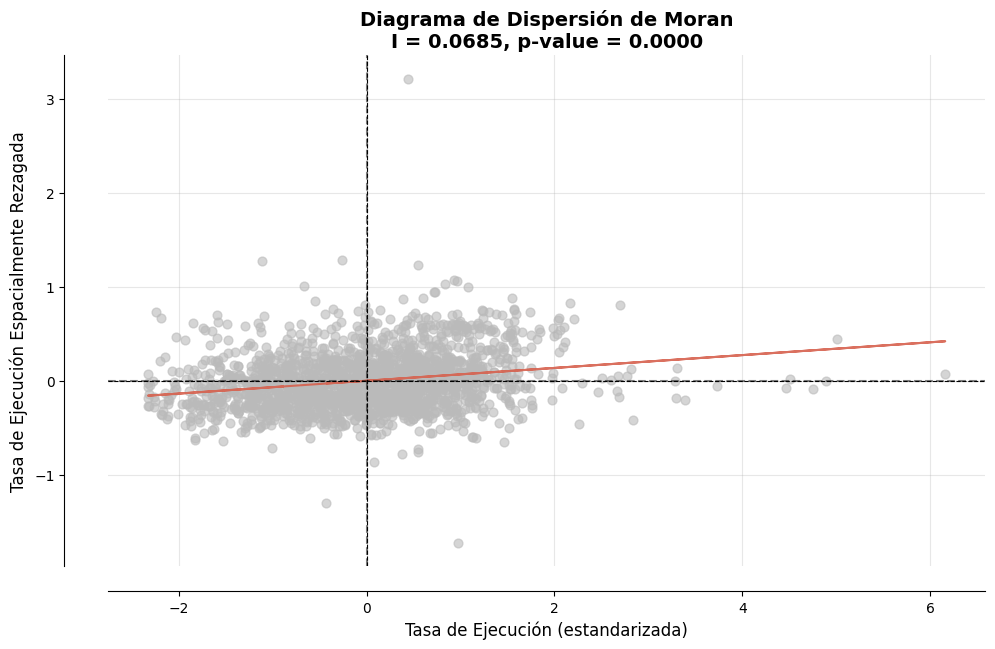

✅ Gráfico generado


In [ ]:
# CELDA 13: Scatter plot de Moran
from splot.esda import moran_scatterplot

print("📈 Generando diagrama de dispersión de Moran...")

fig, ax = plt.subplots(figsize=(10, 8))
moran_scatterplot(moran, ax=ax)
ax.set_xlabel('Tasa de Ejecución (estandarizada)', fontsize=12)
ax.set_ylabel('Tasa de Ejecución Espacialmente Rezagada', fontsize=12)
ax.set_title(f"Diagrama de Dispersión de Moran\nI = {moran.I:.4f}, p-value = {moran.p_norm:.4f}",
             fontsize=14, fontweight='bold')
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.8)
ax.axvline(x=0, color='k', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✅ Gráfico generado")

In [ ]:
# CELDA 14: Moran estratificado por nivel de gobierno
print("🎯 Análisis estratificado por nivel de gobierno...")
print("="*80)

resultados_niveles = {}

for nivel in ['GN', 'GR', 'GL']:
    # Filtrar datos por nivel
    df_nivel = distrito_nivel[distrito_nivel['NIVEL'] == nivel].copy()

    if len(df_nivel) < 30:  # Mínimo para análisis espacial
        print(f"\n{nivel}: Insuficientes observaciones ({len(df_nivel)})")
        continue

    # Crear coordenadas
    coords_nivel = list(zip(df_nivel['longitud'], df_nivel['latitud']))

    # Crear matriz de pesos
    w_nivel = DistanceBand(coords_nivel, threshold=0.9, binary=False, alpha=-1)
    w_nivel.transform = 'R'

    # Calcular Moran
    y_nivel = df_nivel['tasa_ejecucion'].values
    moran_nivel = Moran(y_nivel, w_nivel, permutations=9999)

    resultados_niveles[nivel] = {
        'I': moran_nivel.I,
        'p_value': moran_nivel.p_norm,
        'n_distritos': len(df_nivel),
        'vecinos_promedio': w_nivel.mean_neighbors
    }

    print(f"\n{nivel} ({['Gobierno Nacional', 'Gobiernos Regionales', 'Gobiernos Locales'][['GN','GR','GL'].index(nivel)]})")
    print(f"   Distritos con proyectos: {len(df_nivel):,}")
    print(f"   Moran's I: {moran_nivel.I:.4f}")
    print(f"   P-value: {moran_nivel.p_norm:.4f}")
    print(f"   Vecinos promedio: {w_nivel.mean_neighbors:.1f}")

    if moran_nivel.p_norm < 0.001:
        print(f"   ✅ Autocorrelación ALTAMENTE SIGNIFICATIVA")
    elif moran_nivel.p_norm < 0.05:
        print(f"   ✅ Autocorrelación SIGNIFICATIVA")
    else:
        print(f"   ❌ No significativo")

print("\n" + "="*80)

🎯 Análisis estratificado por nivel de gobierno...
('WARNING: ', 1343, ' is an island (no neighbors)')
('WARNING: ', 1358, ' is an island (no neighbors)')
('WARNING: ', 1383, ' is an island (no neighbors)')
('WARNING: ', 1736, ' is an island (no neighbors)')
('WARNING: ', 1740, ' is an island (no neighbors)')

GN (Gobierno Nacional)
   Distritos con proyectos: 1,742
   Moran's I: 0.0641
   P-value: 0.0000
   Vecinos promedio: 82.1
   ✅ Autocorrelación ALTAMENTE SIGNIFICATIVA
('WARNING: ', 1126, ' is an island (no neighbors)')
('WARNING: ', 1142, ' is an island (no neighbors)')
('WARNING: ', 1165, ' is an island (no neighbors)')
('WARNING: ', 1464, ' is an island (no neighbors)')
('WARNING: ', 1472, ' is an island (no neighbors)')

GR (Gobiernos Regionales)
   Distritos con proyectos: 1,473
   Moran's I: 0.0658
   P-value: 0.0000
   Vecinos promedio: 68.7
   ✅ Autocorrelación ALTAMENTE SIGNIFICATIVA
('WARNING: ', 1384, ' is an island (no neighbors)')
('WARNING: ', 1399, ' is an island (n

In [ ]:
# CELDA 15: Tabla resumen
print("📋 TABLA COMPARATIVA - AUTOCORRELACIÓN POR NIVEL DE GOBIERNO")
print("="*80)

tabla_resumen = pd.DataFrame(resultados_niveles).T
tabla_resumen.columns = ['Moran I', 'P-value', 'N Distritos', 'Vecinos Prom.']
tabla_resumen = tabla_resumen.round(4)

print(tabla_resumen)
print("\n" + "="*80)

# Guardar resultados
tabla_resumen.to_csv('resultados_moran_global.csv')
print("✅ Resultados guardados en: resultados_moran_global.csv")

📋 TABLA COMPARATIVA - AUTOCORRELACIÓN POR NIVEL DE GOBIERNO
    Moran I  P-value  N Distritos  Vecinos Prom.
GN   0.0641      0.0       1742.0        82.0827
GR   0.0658      0.0       1473.0        68.6572
GL   0.0685      0.0       1792.0        85.4676

✅ Resultados guardados en: resultados_moran_global.csv


In [ ]:
# CELDA 16: Análisis LISA (Local Indicators of Spatial Association)
from esda.moran import Moran_Local
from statsmodels.stats.multitest import multipletests

print("📍 Calculando LISA (Indicadores Locales de Asociación Espacial)...")

# Calcular Moran Local
lisa = Moran_Local(y, w, permutations=9999)

print("="*80)
print("RESULTADOS: AUTOCORRELACIÓN ESPACIAL LOCAL (LISA)")
print("="*80)
print(f"Total de distritos analizados: {len(lisa.Is)}")
print(f"Distritos con p-value < 0.05: {(lisa.p_sim < 0.05).sum()}")
print(f"Distritos con p-value < 0.01: {(lisa.p_sim < 0.01).sum()}")

# Aplicar corrección FDR (Benjamini-Hochberg)
_, pvals_fdr, _, _ = multipletests(lisa.p_sim, alpha=0.05, method='fdr_bh')

print(f"\nDespués de corrección FDR:")
print(f"Distritos significativos (FDR < 0.05): {(pvals_fdr < 0.05).sum()}")

# Agregar resultados al GeoDataFrame
gdf_distritos['lisa_I'] = lisa.Is
gdf_distritos['lisa_pvalue'] = lisa.p_sim
gdf_distritos['lisa_pvalue_fdr'] = pvals_fdr
gdf_distritos['lisa_cluster'] = lisa.q  # 1=HH, 2=LH, 3=LL, 4=HL

print("✅ Análisis LISA completado")

📍 Calculando LISA (Indicadores Locales de Asociación Espacial)...
RESULTADOS: AUTOCORRELACIÓN ESPACIAL LOCAL (LISA)
Total de distritos analizados: 1819
Distritos con p-value < 0.05: 673
Distritos con p-value < 0.01: 372

Después de corrección FDR:
Distritos significativos (FDR < 0.05): 376
✅ Análisis LISA completado


In [ ]:
# CELDA 17: Clasificar clusters significativos
print("🎨 Clasificando clusters espaciales...")

# Crear clasificación de clusters
def classify_cluster(row):
    if row['lisa_pvalue_fdr'] >= 0.05:
        return 'No significativo'
    else:
        cluster_map = {1: 'High-High', 2: 'Low-High', 3: 'Low-Low', 4: 'High-Low'}
        return cluster_map.get(row['lisa_cluster'], 'Otro')

gdf_distritos['cluster_tipo'] = gdf_distritos.apply(classify_cluster, axis=1)

# Contar clusters
cluster_counts = gdf_distritos['cluster_tipo'].value_counts()

print("="*80)
print("DISTRIBUCIÓN DE CLUSTERS (FDR < 0.05)")
print("="*80)
print(cluster_counts)
print("\n" + "="*80)

# Identificar distritos en cada cluster
for cluster_name in ['High-High', 'Low-Low', 'High-Low', 'Low-High']:
    if cluster_name in cluster_counts.index:
        print(f"\n{cluster_name} ({cluster_counts[cluster_name]} distritos):")
        cluster_distritos = gdf_distritos[gdf_distritos['cluster_tipo'] == cluster_name]
        print(cluster_distritos[['DEPARTAMENTO', 'DISTRITO', 'tasa_ejecucion_ponderada']].head(10))

🎨 Clasificando clusters espaciales...
DISTRIBUCIÓN DE CLUSTERS (FDR < 0.05)
cluster_tipo
No significativo    1443
Low-Low              135
High-High            110
High-Low              92
Low-High              39
Name: count, dtype: int64


High-High (110 distritos):
    DEPARTAMENTO     DISTRITO  tasa_ejecucion_ponderada
233     APURIMAC     CHACOCHE                109.271676
234     APURIMAC        CIRCA                 94.484441
235     APURIMAC    CURAHUASI                 91.140513
236     APURIMAC    HUANIPACA                126.627426
237     APURIMAC     LAMBRAMA                 94.865113
238     APURIMAC    PICHIRHUA                109.876998
241     APURIMAC  ANDAHUAYLAS                111.880606
242     APURIMAC     ANDARAPA                 98.230806
248     APURIMAC    PACOBAMBA                110.880711
249     APURIMAC      PACUCHA                 87.997420

Low-Low (135 distritos):
    DEPARTAMENTO         DISTRITO  tasa_ejecucion_ponderada
2       AMAZONAS           BA

🗺️ Generando mapa de clusters LISA...


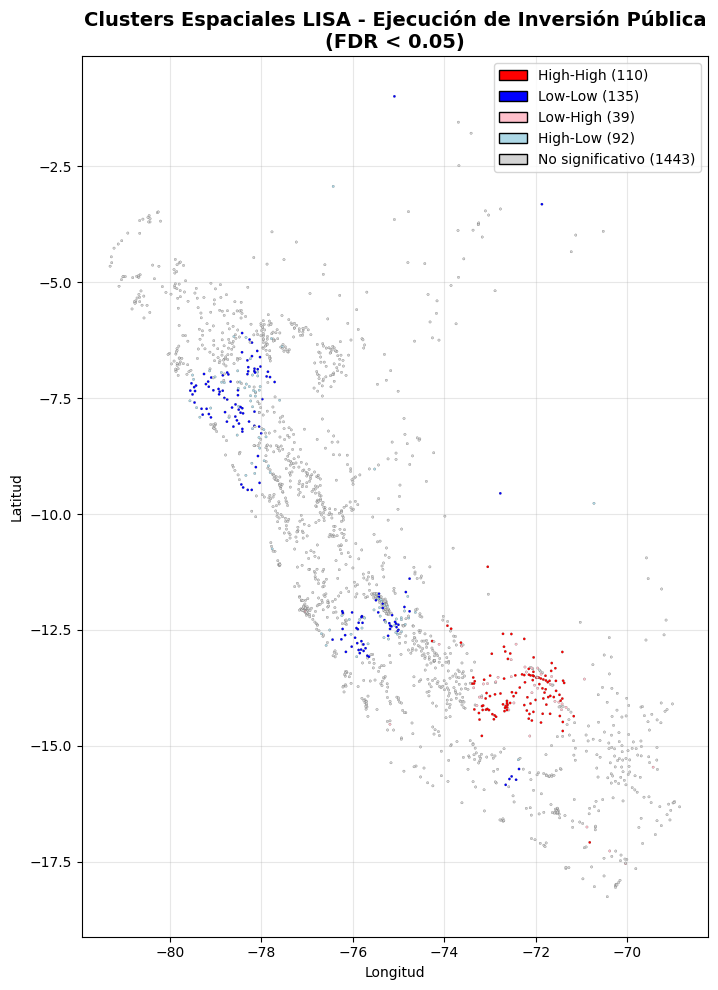

✅ Mapa generado


In [ ]:
# CELDA 18: Visualización de clusters LISA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print("🗺️ Generando mapa de clusters LISA...")

# Crear figura
fig, ax = plt.subplots(figsize=(14, 10))

# Definir colores para clusters
colors = {
    'High-High': 'red',
    'Low-Low': 'blue',
    'High-Low': 'lightblue',
    'Low-High': 'pink',
    'No significativo': 'lightgray'
}

# Plotear
gdf_distritos.plot(
    column='cluster_tipo',
    categorical=True,
    legend=False,
    color=gdf_distritos['cluster_tipo'].map(colors),
    edgecolor='black',
    linewidth=0.1,
    ax=ax,
    markersize=3
)

# Crear leyenda
legend_elements = [
    mpatches.Patch(facecolor='red', edgecolor='black', label=f"High-High ({cluster_counts.get('High-High', 0)})"),
    mpatches.Patch(facecolor='blue', edgecolor='black', label=f"Low-Low ({cluster_counts.get('Low-Low', 0)})"),
    mpatches.Patch(facecolor='pink', edgecolor='black', label=f"Low-High ({cluster_counts.get('Low-High', 0)})"),
    mpatches.Patch(facecolor='lightblue', edgecolor='black', label=f"High-Low ({cluster_counts.get('High-Low', 0)})"),
    mpatches.Patch(facecolor='lightgray', edgecolor='black', label=f"No significativo ({cluster_counts.get('No significativo', 0)})")
]

ax.legend(handles=legend_elements, loc='upper right', fontsize=10)
ax.set_title('Clusters Espaciales LISA - Ejecución de Inversión Pública\n(FDR < 0.05)',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Mapa generado")

In [ ]:
# CELDA 19: Guardar resultados completos
print("💾 Guardando resultados LISA...")

# Guardar CSV con resultados LISA
gdf_distritos.to_csv('resultados_lisa_completo.csv', index=False)

# Guardar solo clusters significativos
clusters_sig = gdf_distritos[gdf_distritos['cluster_tipo'] != 'No significativo']
clusters_sig.to_csv('clusters_significativos.csv', index=False)

# Guardar GeoJSON
gdf_distritos.to_file('clusters_lisa.geojson', driver='GeoJSON')

print("✅ Archivos guardados:")
print("   - resultados_lisa_completo.csv")
print("   - clusters_significativos.csv")
print("   - clusters_lisa.geojson")

💾 Guardando resultados LISA...
✅ Archivos guardados:
   - resultados_lisa_completo.csv
   - clusters_significativos.csv
   - clusters_lisa.geojson


## ANÁLISIS DE PERSISTENCIA TEMPORAL

In [ ]:
# CELDA 20: Preparar datos por períodos temporales
print("📅 Dividiendo datos por períodos temporales...")

# Filtrar data original por períodos
periodo1 = gdf[(gdf['anio_viabilidad'] >= 2019) & (gdf['anio_viabilidad'] <= 2020)].copy()
periodo2 = gdf[(gdf['anio_viabilidad'] >= 2021) & (gdf['anio_viabilidad'] <= 2023)].copy()

print(f"Período 2019-2020: {len(periodo1):,} proyectos")
print(f"Período 2021-2023: {len(periodo2):,} proyectos")

# Agregar por distrito para cada período
def agregar_por_distrito(df_periodo):
    return df_periodo.groupby('UBIGEO').apply(lambda x: pd.Series({
        'DEPARTAMENTO': x['DEPARTAMENTO'].iloc[0],
        'PROVINCIA': x['PROVINCIA'].iloc[0],
        'DISTRITO': x['DISTRITO'].iloc[0],
        'n_proyectos': len(x),
        'monto_viable_total': x['MONTO_VIABLE'].sum(),
        'devengado_total': x['DEVEN_ACUMULADO'].sum(),
        'tasa_ejecucion': (x['DEVEN_ACUMULADO'].sum() / x['MONTO_VIABLE'].sum()) * 100,
        'latitud': x['LATITUD'].mean(),
        'longitud': x['LONGITUD'].mean()
    })).reset_index()

dist_p1 = agregar_por_distrito(periodo1)
dist_p2 = agregar_por_distrito(periodo2)

print(f"\nDistritos con proyectos:")
print(f"  Período 2019-2020: {len(dist_p1):,}")
print(f"  Período 2021-2023: {len(dist_p2):,}")
print(f"\nTasa ejecución promedio:")
print(f"  Período 2019-2020: {dist_p1['tasa_ejecucion'].mean():.2f}%")
print(f"  Período 2021-2023: {dist_p2['tasa_ejecucion'].mean():.2f}%")

📅 Dividiendo datos por períodos temporales...
Período 2019-2020: 31,960 proyectos
Período 2021-2023: 27,334 proyectos

Distritos con proyectos:
  Período 2019-2020: 1,651
  Período 2021-2023: 1,639

Tasa ejecución promedio:
  Período 2019-2020: 69.19%
  Período 2021-2023: 62.35%


In [ ]:
# CELDA 21: Calcular Moran para cada período
from libpysal.weights import DistanceBand
from esda.moran import Moran

print("\n" + "="*80)
print("AUTOCORRELACIÓN ESPACIAL POR PERÍODO")
print("="*80)

resultados_temporales = {}

for nombre, df_dist in [('2019-2020', dist_p1), ('2021-2023', dist_p2)]:
    print(f"\n📊 Período: {nombre}")
    print("-"*40)

    # Crear coordenadas
    coords = list(zip(df_dist['longitud'], df_dist['latitud']))

    # Matriz de pesos
    w_temp = DistanceBand(coords, threshold=0.9, binary=False, alpha=-1)
    w_temp.transform = 'R'

    # Calcular Moran
    y_temp = df_dist['tasa_ejecucion'].values
    moran_temp = Moran(y_temp, w_temp, permutations=9999)

    # Guardar resultados
    resultados_temporales[nombre] = {
        'I': moran_temp.I,
        'EI': moran_temp.EI,
        'p_value': moran_temp.p_norm,
        'z_score': moran_temp.z_norm,
        'n_distritos': len(df_dist),
        'tasa_promedio': df_dist['tasa_ejecucion'].mean()
    }

    print(f"  Distritos: {len(df_dist):,}")
    print(f"  Moran's I: {moran_temp.I:.4f}")
    print(f"  Z-score: {moran_temp.z_norm:.4f}")
    print(f"  P-value: {moran_temp.p_norm:.6f}")
    print(f"  Tasa ejecución promedio: {df_dist['tasa_ejecucion'].mean():.2f}%")

    if moran_temp.p_norm < 0.001:
        print(f"  ✅ Autocorrelación ALTAMENTE SIGNIFICATIVA")
    elif moran_temp.p_norm < 0.05:
        print(f"  ✅ Autocorrelación SIGNIFICATIVA")
    else:
        print(f"  ❌ No significativo")

print("\n" + "="*80)


AUTOCORRELACIÓN ESPACIAL POR PERÍODO

📊 Período: 2019-2020
----------------------------------------
('WARNING: ', 1250, ' is an island (no neighbors)')
('WARNING: ', 1252, ' is an island (no neighbors)')
('WARNING: ', 1292, ' is an island (no neighbors)')
('WARNING: ', 1643, ' is an island (no neighbors)')
('WARNING: ', 1649, ' is an island (no neighbors)')
  Distritos: 1,651
  Moran's I: 0.0418
  Z-score: 5.4495
  P-value: 0.000000
  Tasa ejecución promedio: 69.19%
  ✅ Autocorrelación ALTAMENTE SIGNIFICATIVA

📊 Período: 2021-2023
----------------------------------------
('WARNING: ', 1257, ' is an island (no neighbors)')
('WARNING: ', 1272, ' is an island (no neighbors)')
('WARNING: ', 1294, ' is an island (no neighbors)')
('WARNING: ', 1295, ' is an island (no neighbors)')
('WARNING: ', 1297, ' is an island (no neighbors)')
('WARNING: ', 1298, ' is an island (no neighbors)')
('WARNING: ', 1629, ' is an island (no neighbors)')
('WARNING: ', 1637, ' is an island (no neighbors)')
  Dis

In [ ]:
# CELDA 22: Calcular LISA para cada período
from esda.moran import Moran_Local
from statsmodels.stats.multitest import multipletests

print("\n🎯 Calculando LISA por período...")

lisa_p1 = None
lisa_p2 = None
gdf_p1 = None
gdf_p2 = None

for nombre, df_dist in [('2019-2020', dist_p1), ('2021-2023', dist_p2)]:
    print(f"\nPeríodo: {nombre}")

    # Crear coordenadas y matriz
    coords = list(zip(df_dist['longitud'], df_dist['latitud']))
    w_temp = DistanceBand(coords, threshold=0.9, binary=False, alpha=-1)
    w_temp.transform = 'R'

    # LISA
    y_temp = df_dist['tasa_ejecucion'].values
    lisa_temp = Moran_Local(y_temp, w_temp, permutations=9999)

    # FDR correction
    _, pvals_fdr, _, _ = multipletests(lisa_temp.p_sim, alpha=0.05, method='fdr_bh')

    # Crear GeoDataFrame
    geometry = [Point(xy) for xy in zip(df_dist['longitud'], df_dist['latitud'])]
    gdf_temp = gpd.GeoDataFrame(df_dist, geometry=geometry, crs='EPSG:4326')

    # Agregar resultados LISA
    gdf_temp['lisa_I'] = lisa_temp.Is
    gdf_temp['lisa_pvalue'] = lisa_temp.p_sim
    gdf_temp['lisa_pvalue_fdr'] = pvals_fdr
    gdf_temp['lisa_cluster'] = lisa_temp.q

    # Clasificar
    def classify_cluster(row):
        if row['lisa_pvalue_fdr'] >= 0.05:
            return 'No significativo'
        else:
            cluster_map = {1: 'High-High', 2: 'Low-High', 3: 'Low-Low', 4: 'High-Low'}
            return cluster_map.get(row['lisa_cluster'], 'Otro')

    gdf_temp['cluster_tipo'] = gdf_temp.apply(classify_cluster, axis=1)

    # Contar
    cluster_counts = gdf_temp['cluster_tipo'].value_counts()
    print(f"  Clusters significativos (FDR<0.05): {(pvals_fdr < 0.05).sum()}")
    print(cluster_counts)

    # Guardar referencias
    if nombre == '2019-2020':
        lisa_p1 = lisa_temp
        gdf_p1 = gdf_temp
    else:
        lisa_p2 = lisa_temp
        gdf_p2 = gdf_temp

print("\n✅ LISA calculado para ambos períodos")


🎯 Calculando LISA por período...

Período: 2019-2020
('WARNING: ', 1250, ' is an island (no neighbors)')
('WARNING: ', 1252, ' is an island (no neighbors)')
('WARNING: ', 1292, ' is an island (no neighbors)')
('WARNING: ', 1643, ' is an island (no neighbors)')
('WARNING: ', 1649, ' is an island (no neighbors)')
  Clusters significativos (FDR<0.05): 122
cluster_tipo
No significativo    1529
Low-Low               56
High-Low              30
High-High             18
Low-High              18
Name: count, dtype: int64

Período: 2021-2023
('WARNING: ', 1257, ' is an island (no neighbors)')
('WARNING: ', 1272, ' is an island (no neighbors)')
('WARNING: ', 1294, ' is an island (no neighbors)')
('WARNING: ', 1295, ' is an island (no neighbors)')
('WARNING: ', 1297, ' is an island (no neighbors)')
('WARNING: ', 1298, ' is an island (no neighbors)')
('WARNING: ', 1629, ' is an island (no neighbors)')
('WARNING: ', 1637, ' is an island (no neighbors)')
  Clusters significativos (FDR<0.05): 60
clu

In [ ]:
# CELDA 23: Analizar persistencia de clusters
print("\n🔄 Analizando persistencia de clusters...")

# Encontrar distritos comunes en ambos períodos
ubigeos_comunes = set(gdf_p1['UBIGEO']) & set(gdf_p2['UBIGEO'])
print(f"Distritos presentes en ambos períodos: {len(ubigeos_comunes):,}")

# Crear dataframe de comparación
comparacion = pd.DataFrame({
    'UBIGEO': list(ubigeos_comunes)
})

# Merge con clusters de cada período
comparacion = comparacion.merge(
    gdf_p1[['UBIGEO', 'DEPARTAMENTO', 'DISTRITO', 'cluster_tipo', 'tasa_ejecucion']],
    on='UBIGEO',
    how='left',
    suffixes=('', '_p1')
)
comparacion = comparacion.merge(
    gdf_p2[['UBIGEO', 'cluster_tipo', 'tasa_ejecucion']],
    on='UBIGEO',
    how='left',
    suffixes=('_p1', '_p2')
)

# Renombrar columnas
comparacion.columns = ['UBIGEO', 'DEPARTAMENTO', 'DISTRITO', 'cluster_p1', 'tasa_p1', 'cluster_p2', 'tasa_p2']

# Crear matriz de transición
print("\n" + "="*80)
print("MATRIZ DE TRANSICIÓN DE CLUSTERS (2019-2020 → 2021-2023)")
print("="*80)

matriz_transicion = pd.crosstab(
    comparacion['cluster_p1'],
    comparacion['cluster_p2'],
    margins=True,
    margins_name='Total'
)

print(matriz_transicion)
print("\n" + "="*80)


🔄 Analizando persistencia de clusters...
Distritos presentes en ambos períodos: 1,504

MATRIZ DE TRANSICIÓN DE CLUSTERS (2019-2020 → 2021-2023)
cluster_p2        High-High  High-Low  Low-High  Low-Low  No significativo  \
cluster_p1                                                                   
High-High                 7         0         2        0                 9   
High-Low                  0         1         0        1                22   
Low-High                  4         0         1        0                12   
Low-Low                   0         2         0        1                53   
No significativo          8        15         3       10              1353   
Total                    19        18         6       12              1449   

cluster_p2        Total  
cluster_p1               
High-High            18  
High-Low             24  
Low-High             17  
Low-Low              56  
No significativo   1389  
Total              1504  



In [ ]:
# CELDA 24: Calcular persistencia por tipo de cluster
print("\n📊 TASAS DE PERSISTENCIA POR TIPO DE CLUSTER")
print("="*80)

persistencia = {}

for cluster_tipo in ['High-High', 'Low-Low', 'High-Low', 'Low-High']:
    # Distritos que eran de este tipo en P1
    distritos_p1 = comparacion[comparacion['cluster_p1'] == cluster_tipo]

    if len(distritos_p1) > 0:
        # De esos, cuántos siguen siendo del mismo tipo en P2
        persistentes = distritos_p1[distritos_p1['cluster_p2'] == cluster_tipo]
        tasa_persistencia = (len(persistentes) / len(distritos_p1)) * 100

        persistencia[cluster_tipo] = {
            'n_inicial': len(distritos_p1),
            'n_persistente': len(persistentes),
            'tasa_persistencia': tasa_persistencia
        }

        print(f"\n{cluster_tipo}:")
        print(f"  Distritos en 2019-2020: {len(distritos_p1)}")
        print(f"  Persistentes en 2021-2023: {len(persistentes)}")
        print(f"  Tasa de persistencia: {tasa_persistencia:.1f}%")

        # Mostrar algunos ejemplos de distritos persistentes
        if len(persistentes) > 0:
            print(f"  Ejemplos de distritos persistentes:")
            print(persistentes[['DEPARTAMENTO', 'DISTRITO', 'tasa_p1', 'tasa_p2']].head(5).to_string(index=False))

print("\n" + "="*80)

# Crear tabla resumen
tabla_persistencia = pd.DataFrame(persistencia).T
tabla_persistencia.to_csv('persistencia_temporal_clusters.csv')
print("\n✅ Resultados guardados en: persistencia_temporal_clusters.csv")


📊 TASAS DE PERSISTENCIA POR TIPO DE CLUSTER

High-High:
  Distritos en 2019-2020: 18
  Persistentes en 2021-2023: 7
  Tasa de persistencia: 38.9%
  Ejemplos de distritos persistentes:
DEPARTAMENTO              DISTRITO    tasa_p1    tasa_p2
     HUANUCO           CANCHABAMBA 143.350665 104.122935
     HUANUCO      SAN BUENAVENTURA  99.337003 149.035886
      ANCASH                 YAUYA  94.352142 136.330229
      ANCASH ELEAZAR GUZMAN BARRON 126.397221  87.423193
      ANCASH FIDEL OLIVAS ESCUDERO 106.049522 233.526941

Low-Low:
  Distritos en 2019-2020: 56
  Persistentes en 2021-2023: 1
  Tasa de persistencia: 1.8%
  Ejemplos de distritos persistentes:
DEPARTAMENTO       DISTRITO   tasa_p1   tasa_p2
      LORETO TORRES CAUSANA 60.909978 40.011449

High-Low:
  Distritos en 2019-2020: 24
  Persistentes en 2021-2023: 1
  Tasa de persistencia: 4.2%
  Ejemplos de distritos persistentes:
DEPARTAMENTO DISTRITO    tasa_p1   tasa_p2
       PIURA HUARMACA 104.004643 70.380168

Low-High:
  Dis


🗺️ Generando mapas comparativos...


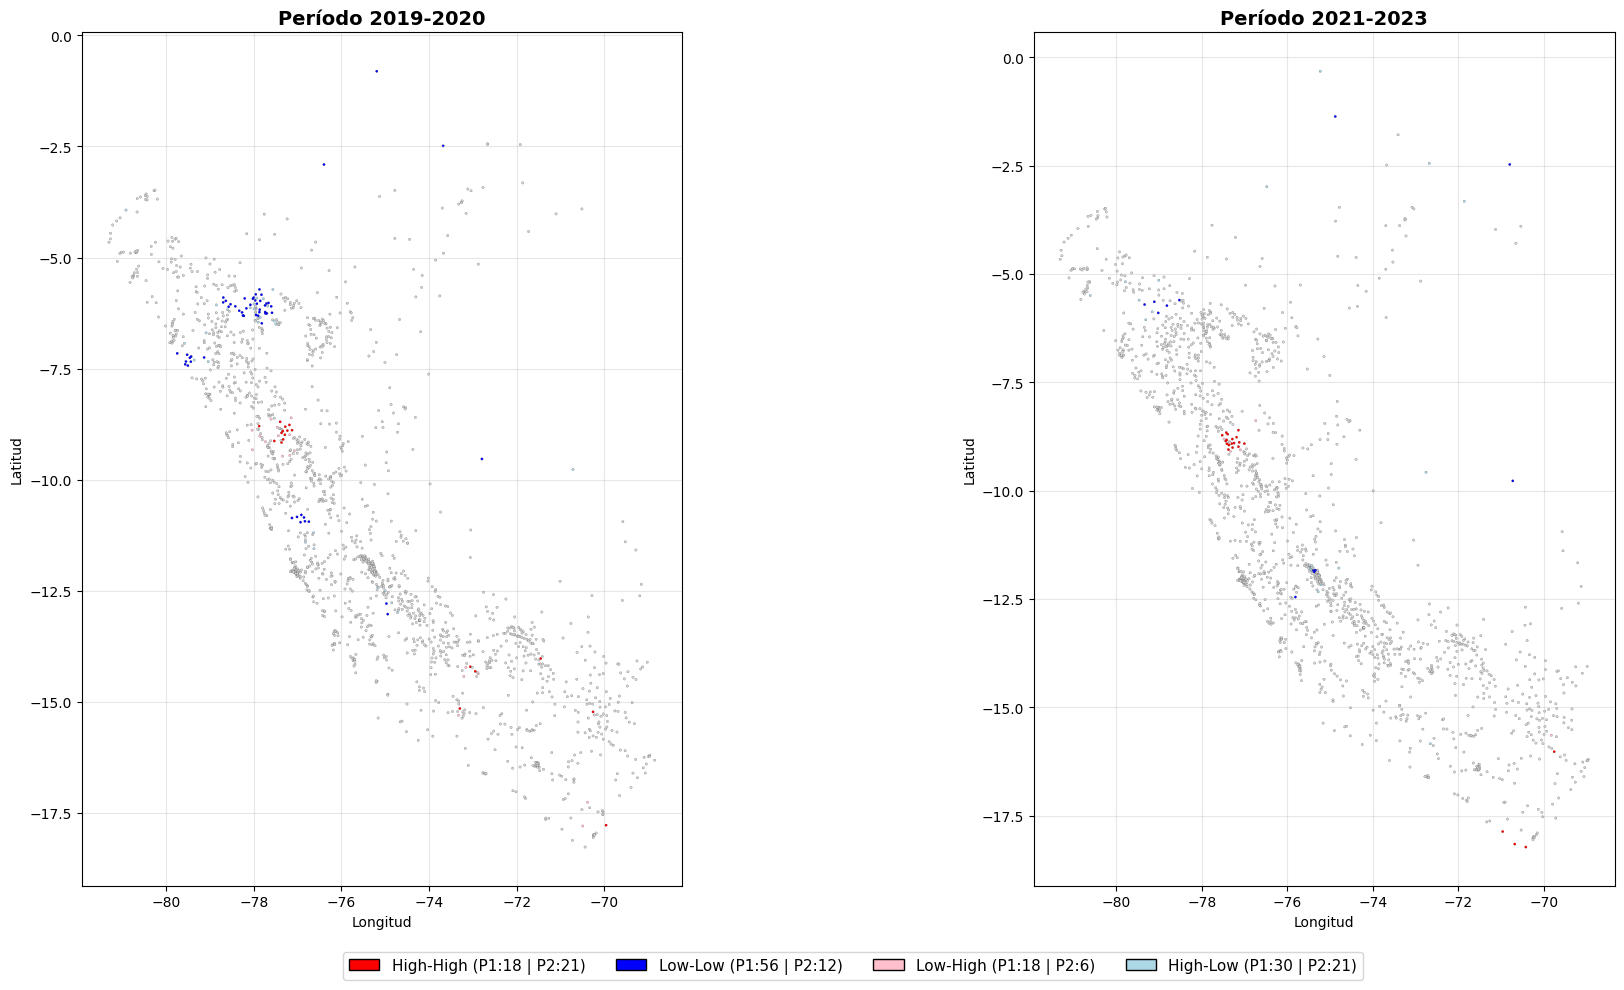

✅ Mapas comparativos generados


In [ ]:
# CELDA 25: Visualización comparativa de períodos
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

print("\n🗺️ Generando mapas comparativos...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

colors = {
    'High-High': 'red',
    'Low-Low': 'blue',
    'High-Low': 'lightblue',
    'Low-High': 'pink',
    'No significativo': 'lightgray'
}

# Mapa Período 1
gdf_p1.plot(
    column='cluster_tipo',
    categorical=True,
    legend=False,
    color=gdf_p1['cluster_tipo'].map(colors),
    edgecolor='black',
    linewidth=0.1,
    ax=ax1,
    markersize=3
)
ax1.set_title('Período 2019-2020', fontsize=14, fontweight='bold')
ax1.set_xlabel('Longitud')
ax1.set_ylabel('Latitud')
ax1.grid(True, alpha=0.3)

# Mapa Período 2
gdf_p2.plot(
    column='cluster_tipo',
    categorical=True,
    legend=False,
    color=gdf_p2['cluster_tipo'].map(colors),
    edgecolor='black',
    linewidth=0.1,
    ax=ax2,
    markersize=3
)
ax2.set_title('Período 2021-2023', fontsize=14, fontweight='bold')
ax2.set_xlabel('Longitud')
ax2.set_ylabel('Latitud')
ax2.grid(True, alpha=0.3)

# Leyenda compartida
p1_counts = gdf_p1['cluster_tipo'].value_counts()
p2_counts = gdf_p2['cluster_tipo'].value_counts()

legend_elements = [
    mpatches.Patch(facecolor='red', edgecolor='black',
                   label=f"High-High (P1:{p1_counts.get('High-High',0)} | P2:{p2_counts.get('High-High',0)})"),
    mpatches.Patch(facecolor='blue', edgecolor='black',
                   label=f"Low-Low (P1:{p1_counts.get('Low-Low',0)} | P2:{p2_counts.get('Low-Low',0)})"),
    mpatches.Patch(facecolor='pink', edgecolor='black',
                   label=f"Low-High (P1:{p1_counts.get('Low-High',0)} | P2:{p2_counts.get('Low-High',0)})"),
    mpatches.Patch(facecolor='lightblue', edgecolor='black',
                   label=f"High-Low (P1:{p1_counts.get('High-Low',0)} | P2:{p2_counts.get('High-Low',0)})")
]

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.05),
           ncol=4, fontsize=11, frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

print("✅ Mapas comparativos generados")

In [ ]:
# CELDA EXTRA: Guardar figuras
import matplotlib.pyplot as plt

# Figura 1: Scatter Moran (ya la generaste en paso 13, solo guarda)
# (Vuelve a ejecutar paso 13 y agrega al final:)
plt.savefig('moran_scatterplot.png', dpi=300, bbox_inches='tight')

# Figura 2: Mapa clusters (ya la generaste en paso 18, agrega al final:)
plt.savefig('mapa_clusters_lisa.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## EXPORTAR DATOS PARA GEE

In [ ]:
# CELDA 26: Preparar datos para Google Earth Engine
print("📦 Preparando datos para Google Earth Engine...")

# 1. Exportar datos de proyectos individuales (muestra)
# GEE tiene límite de features, usamos muestra representativa
gdf_sample = gdf.sample(n=min(50000, len(gdf)), random_state=42)

# Seleccionar columnas importantes
gdf_export = gdf_sample[['LATITUD', 'LONGITUD', 'tasa_ejecucion',
                          'MONTO_VIABLE', 'NIVEL', 'DEPARTAMENTO',
                          'DISTRITO', 'FUNCION', 'geometry']].copy()

# Guardar como GeoJSON
gdf_export.to_file('proyectos_para_gee.geojson', driver='GeoJSON')
print(f"✅ Exportados {len(gdf_export):,} proyectos → proyectos_para_gee.geojson")

# 2. Exportar datos distritales con clusters
gdf_distritos_export = gdf_distritos[['UBIGEO', 'DEPARTAMENTO', 'DISTRITO',
                                       'latitud_centroid', 'longitud_centroid',
                                       'n_proyectos', 'tasa_ejecucion_ponderada',
                                       'cluster_tipo', 'lisa_pvalue_fdr',
                                       'geometry']].copy()

gdf_distritos_export.to_file('distritos_clusters_gee.geojson', driver='GeoJSON')
print(f"✅ Exportados {len(gdf_distritos_export):,} distritos → distritos_clusters_gee.geojson")

# 3. Crear CSV simplificado para upload rápido
csv_proyectos = gdf_sample[['LATITUD', 'LONGITUD', 'tasa_ejecucion',
                             'MONTO_VIABLE', 'NIVEL']].copy()
csv_proyectos.to_csv('proyectos_gee.csv', index=False)
print(f"✅ CSV creado → proyectos_gee.csv")

print("\n" + "="*80)
print("📥 DESCARGA ESTOS ARCHIVOS:")
print("="*80)
print("1. proyectos_gee.csv")
print("2. distritos_clusters_gee.geojson")
print("\nLos subiremos a Google Earth Engine en el siguiente paso")

📦 Preparando datos para Google Earth Engine...
✅ Exportados 50,000 proyectos → proyectos_para_gee.geojson
✅ Exportados 1,819 distritos → distritos_clusters_gee.geojson
✅ CSV creado → proyectos_gee.csv

📥 DESCARGA ESTOS ARCHIVOS:
1. proyectos_gee.csv
2. distritos_clusters_gee.geojson

Los subiremos a Google Earth Engine en el siguiente paso


In [ ]:
# CELDA 27: Descargar archivos para GEE
from google.colab import files

print("💾 Descargando archivos...")

# Descargar CSV de proyectos
files.download('proyectos_gee.csv')
print("✅ Descargado: proyectos_gee.csv")

# Descargar GeoJSON de clusters
files.download('distritos_clusters_gee.geojson')
print("✅ Descargado: distritos_clusters_gee.geojson")

print("\n📌 SIGUIENTE PASO:")
print("Ve a: https://code.earthengine.google.com")
print("Y sube estos archivos como Assets")

💾 Descargando archivos...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Descargado: proyectos_gee.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Descargado: distritos_clusters_gee.geojson

📌 SIGUIENTE PASO:
Ve a: https://code.earthengine.google.com
Y sube estos archivos como Assets
